### Preinstall

Please install the below python libraries to run this notebook successfully
>1. pip install scikit-plot  (or conda install -c conda-forge scikit-plot)
>2. pip install PrettyTable
>3. pip install altair
>4. pip install imblearn

### Data Cleaning procedures applied 
> 1. In sitting/dataset8.csv, only 484 lines were present. To keep the datasets uniform, combination of the mean of the data was added as a new row. 

> 2. Datasets had an extra comma in the end of the files. It was removed manually.

> 3. binding2/dataset4.scv had space as the delimiter. This was replaced with comma to keep all datsets uniform. 

**Please use the datasets that are provided with this notebook. You can import the complete folder and change the folder path and proceed to execute further.** 

### Execution Steps
> All code cells apart from the first 3 code cells are independent and can be run individually. 
> To run any code cell from 4 - last, please run first 3 cells and run the one required.

### Considerations
> For binary classification : Class-0 is bending and Class-1 is other activities
- For Multiclass classification : 
    - bending1 : 0 
    - bending2 : 0 
    - cycling : 1 
    - lying : 2 
    - sitting : 3
    - standing : 4 
    - walking : 5

 ### Initial Study 
 
Different time-domain features are employed to analyze time series classification. 

Simple statistical features
- Mean
- Median
- Maximum & Minimum values
- Quartile
- Standard Deviation
- Skewness
- Kurtosis
- Omnibus

Time series analysis related features
- The 𝑑×𝑑−1 Cross-Correlations between each dimension and the 𝑑 Auto-Correlations
- Orders of the autoregressive (AR), integrated (I) and moving average (MA) part of an estimated ARIMA model
- Parameters of the AR and  MA part

Frequency domain related features
- frequencies of the 𝑘 peaks in amplitude in the DFTs for the detrended 𝑑 dimensions
- 𝑘-quantiles of these DFTs
 

In [1]:
import glob
import os
import re
import copy
import pandas as pd
import numpy as np
import itertools
import time
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
# import scikitplot as skplt
from math import log
from scipy.stats import norm
from itertools import cycle
from numpy import interp
from prettytable import PrettyTable
from imblearn.over_sampling import SMOTE 
from scikitplot.metrics import plot_roc as plt_ski_roc
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, RFE, SelectFromModel, VarianceThreshold
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from statsmodels.tools.eval_measures import aic, bic, rmse
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import roc_curve, auc, confusion_matrix,plot_confusion_matrix,log_loss, mean_squared_error,accuracy_score,roc_auc_score
from sklearn import metrics
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import altair as alt

# If you do not want to see warnings uncomment below line and execute
# warnings.simplefilter('ignore', category=UserWarning)

In [2]:
def list_diff(list1, list2): 
    return (list(set(list1) - set(list2))) 

def retrieve_datasets():
    bending_ds_3 = glob.glob(os.path.join("/Users/lsandip/Desktop/LabSpace/Homework_3/AReM/bending*/","dataset3.csv"))
    all_test_ds = glob.glob(os.path.join("/Users/lsandip/Desktop/LabSpace/Homework_3/AReM/*/","dataset[1-3].csv"))
    all_ds = glob.glob(os.path.join("/Users/lsandip/Desktop/LabSpace/Homework_3/AReM/*/","*.csv"))
    
    return all_ds,list_diff(all_ds,list_diff(all_test_ds,bending_ds_3)), list_diff(all_test_ds,bending_ds_3)

all_ds, train_ds, test_ds = retrieve_datasets()

# Statsmodels convergence information. To disable, set disp=0
disp = 1

### Commonly Reused Definitions

In [3]:
class copyDataframe:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe

def describe(df, stats):
    
    d = df.describe()
    return d.append(df.reindex(d.columns, axis=1).agg(stats))

def createcolumns(size,pruned):
    
    #SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    column_names = ["Instance","Class"]
    
    if bool(pruned):
        for i in range(1,size):
            column_names.append('min'+str(i))      #col_names.append('min'+str(i).translate(SUB))
            column_names.append("max"+str(i))      #col_names.append("max"+str(i).translate(SUB))
            column_names.append("mean"+str(i))     #col_names.append("mean"+str(i).translate(SUB))
    else:
        for i in range(1,size):
            column_names.append('min'+str(i))      #col_names.append('min'+str(i).translate(SUB))
            column_names.append("max"+str(i))      #col_names.append("max"+str(i).translate(SUB))
            column_names.append("mean"+str(i))     #col_names.append("mean"+str(i).translate(SUB))
            column_names.append("median"+str(i))   #col_names.append("median"+str(i).translate(SUB))
            column_names.append("std"+str(i))      #col_names.append("std"+str(i).translate(SUB))
            column_names.append("1st quart"+str(i))#col_names.append("1st quart"+str(i).translate(SUB))
            column_names.append("3rd quart"+str(i))#col_names.append("3rd quart"+str(i).translate(SUB))
            
    return column_names

def computestats(temp_df,pruned):
    
    d = describe(temp_df,['median']).T.drop(columns=["count","50%"])  
    if bool(pruned):
        return d[["min","max","mean"]]
    else:
        return d[["min","max","mean","median","std","25%","75%"]]   

def assign_class(f,multiclass): 
    
    folder = str(str(f).split("/")[-2:][0])   
    
    if bool(multiclass):
        
        activity = { 
            "bending1": 0, 
            "bending2": 0, 
            "cycling": 1, 
            "lying": 2, 
            "sitting": 3, 
            "standing": 4, 
            "walking": 5
        } 
        return activity.get(folder, None)
    
    else:
        class_label = 0 if folder.startswith('bending') else 1
        return class_label

def extract_features(dataset,split_size,col_size,pruned,multiclass):
    
    stats_df = pd.DataFrame(columns = createcolumns(col_size,pruned))
    counter, class_val = 0 ,0
    
    for idx,f in enumerate(dataset):            
        counter+=1
        temp_df = pd.read_csv(f,skiprows=range(0,4),index_col=[0]) 
        split_array = np.array_split(temp_df , split_size)
        
        for i in range(len(split_array)): 
            split_array[i] = split_array[i].reset_index(drop=True)

        formatted_df = pd.concat(split_array,axis=1)
        stats_df=stats_df.append(pd.Series(np.concatenate((counter,assign_class(f,multiclass)
                                                           ,computestats(formatted_df,pruned)
                                                           .to_numpy().flatten()),axis=None),
                                           index=stats_df.columns), ignore_index=True)
    return stats_df

def plt_confusion_matrix(clf, X_test, y_test,class_names):
    
    np.set_printoptions(precision=2)
    titles_options = [("Confusion matrix, without normalization", None)]
    
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test, 
                                    display_labels=class_names,
                                    cmap=plt.cm.Blues, 
                                    normalize=normalize)
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)
    plt.show()
    
def compute_pvalues(x,y):
    clf = LogisticRegression()
    clf.fit(x, y.ravel())
    
    x_ = sm.add_constant(x)
    res_sm = sm.Logit(y, x_).fit(method="lbfgs", maxiter=1e3) # x_ here
    #print("statsmodel pvalues -->\n",res_sm.pvalues)
    
    return logit_pvalue(clf,x)

def no_constant_pvalues(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression without the intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0])+1# 1 is removed here
    coefs = np.concatenate([[1], model.coef_[0]])  # model.intercept_ is removed
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

def plt_roc_curve(y_test, y_score, n_classes):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    sns.set(style="darkgrid")
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
        
def format_report(res_sm): 
    table = PrettyTable()
    i=0
    table.field_names = ["Features", "p-values","Coefficients (Beta)"]  
    for param, pvalue in res_sm.pvalues.items():
        table.add_row([param, pvalue ,res_sm.params[i]])
        i+=1
    return table

def scalar_standardization(x_):
    
    # sc = QuantileTransformer(n_quantiles=10)
    # sc = MinMaxScaler()
    sc = StandardScaler()
    X_std_df = pd.DataFrame(sc.fit_transform(x_), columns = x_.columns)
    
    return X_std_df

def evaluation_analysis(true_label,predicted): 
    
    print("f1 score macro       :",metrics.f1_score(true_label, predicted, average='macro'))     
    print("f1 score micro       :",metrics.f1_score(true_label, predicted, average='micro'))
    print("precision score      :",metrics.precision_score(true_label, predicted, average='macro'))
    print("recall score         :",metrics.recall_score(true_label, predicted, average='macro'))
    print("log_loss             :", metrics.log_loss(true_label, predicted))
    print("zero_one_loss        :", metrics.zero_one_loss(true_label, predicted))
    print("AUC & ROC            :",metrics.roc_auc_score(true_label, predicted))
    print("classification_report:\n\n", metrics.classification_report(true_label, predicted))

def cal_min_deviance(dev_list):
    
    min_deviance = 0
    
    for indx, value in enumerate(dev_list):
        if value > 1:
            if indx == 0:
                min_deviance = value
            else:
                if value < min_deviance:
                    min_deviance = value
                    
    return min_deviance

def format_table(dic):
    
    table = PrettyTable()
    
    remove_set = ["Pruned Features","Report"]
    for key,val in dic.items():
        if key not in remove_set:
            table.add_column(key,val)
            
    return table

def plot_multiclass_roc(y_test, y_score, n_classes):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(num=None, figsize=(10, 6), dpi=75, edgecolor='k')
    sns.set(style="darkgrid")
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','darkblue','brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class classification')
    plt.legend(loc="lower right")
    plt.show()
    
def minority_upsampling(df_):
    '''
    The minority class which is Class=0 is upsampled to negate class imbalance. So 
    the number of samples is adjusted accordingly to obtain a balanced class distribution 
    in the confusion matrix
    '''
    # Separate majority and minority classes
    df_majority = df_[df_.Class==1]
    df_minority = df_[df_.Class==0]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,    # sample with replacement
                                     n_samples=20,    # to match majority class
                                     random_state=123)# reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    return df_upsampled.reset_index(drop=True)

def best_model_selector():
    
    sklearn_stats = {
        "l":[],
        "Total Features":[],
        "Selected Features":[], 
        "CV Score":[],
        "Pruned Features":[],      
        "Intercept":[],    
        "Calculated Deviance" : []
    }
    statsmodels_stats = {
        "l":[],
        "Deviance":[],  
        "Psuedo R Squared":[],
        "AIC":[],
        "BIC":[], 
    }
    df1 = pd.DataFrame(sklearn_stats) 
    pd.concat([
    pd.DataFrame(sklearn_stats), 
    pd.DataFrame(statsmodels_stats)]).reset_index(drop=True)
        
def format_sklearn_params(clf, x):
    
    data = {
        
        "Features" : x.columns.insert(0, "constant"),
        "Coeffs"   : np.concatenate([model.intercept_, model.coef_[0]]),
        "p-values" : no_constant_pvalues(clf, x)
    }
    
    return format_table(data)

> Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [4]:
feature_ext_df = extract_features(all_ds,1,7,False,False)
feature_ext_df.style

,Instance,Class,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,mean2,median2,std2,1st quart2,3rd quart2,min3,max3,mean3,median3,std3,1st quart3,3rd quart3,min4,max4,mean4,median4,std4,1st quart4,3rd quart4,min5,max5,mean5,median5,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1.000000,0.000000,36.250000,48.000000,43.969125,44.500000,1.618364,43.310000,44.670000,0.000000,1.500000,0.413125,0.470000,0.263111,0.430000,0.500000,1.500000,26.330000,15.868021,16.250000,3.742420,14.250000,18.000000,0.000000,5.170000,0.666354,0.470000,0.788985,0.000000,0.940000,11.330000,30.750000,22.103750,21.670000,3.318301,20.500000,23.750000,0.000000,2.960000,0.555313,0.490000,0.487826,0.000000,0.830000
1,2.000000,0.000000,37.000000,48.000000,43.454958,43.250000,1.386098,42.500000,45.000000,0.000000,1.580000,0.378083,0.470000,0.315566,0.000000,0.500000,5.750000,27.000000,15.793333,15.000000,3.847638,13.000000,18.270000,0.000000,10.030000,0.849354,0.500000,0.995761,0.430000,1.120000,8.000000,33.500000,23.034792,23.500000,2.488862,22.250000,24.000000,0.000000,5.260000,0.679646,0.500000,0.622534,0.430000,0.870000
2,3.000000,0.000000,33.000000,47.750000,42.179813,43.500000,3.670666,39.150000,45.000000,0.000000,3.000000,0.696042,0.500000,0.630860,0.000000,1.120000,8.500000,30.000000,22.183625,23.000000,3.810469,20.500000,24.372500,0.000000,5.150000,0.989917,0.830000,0.953730,0.430000,1.300000,20.000000,38.670000,33.493917,35.000000,3.849448,30.457500,36.330000,0.000000,2.180000,0.613521,0.500000,0.524317,0.000000,1.000000
3,4.000000,0.000000,33.000000,45.750000,41.678063,41.750000,2.243490,41.330000,42.750000,0.000000,2.830000,0.535979,0.500000,0.405469,0.430000,0.710000,3.000000,28.250000,19.006562,19.125000,4.087107,16.500000,22.062500,0.000000,6.420000,0.841875,0.500000,0.928801,0.430000,1.120000,23.670000,37.500000,29.857083,30.000000,2.411026,28.457500,31.250000,0.000000,1.790000,0.383292,0.430000,0.389164,0.000000,0.500000
4,5.000000,0.000000,37.250000,45.000000,40.624792,40.500000,1.476967,39.250000,42.000000,0.000000,1.300000,0.358604,0.430000,0.322605,0.000000,0.500000,4.000000,29.500000,19.040937,19.250000,4.462952,16.000000,23.250000,0.000000,7.230000,0.832542,0.500000,0.965659,0.000000,1.120000,27.250000,38.250000,34.311292,35.000000,2.188449,33.000000,36.000000,0.000000,1.920000,0.570583,0.430000,0.582915,0.000000,1.300000
5,6.000000,0.000000,38.000000,45.670000,42.812812,42.500000,1.435550,42.000000,43.670000,0.000000,1.220000,0.372438,0.470000,0.289158,0.000000,0.500000,2.000000,29.500000,20.096979,21.000000,3.893737,19.000000,22.250000,0.000000,5.760000,0.876438,0.500000,1.047259,0.000000,1.145000,27.670000,38.500000,33.024583,33.000000,1.995255,32.000000,34.500000,0.000000,3.110000,0.571083,0.430000,0.601010,0.000000,1.300000
6,7.000000,0.000000,35.000000,47.400000,43.954500,44.330000,1.558835,43.000000,45.000000,0.000000,1.700000,0.426250,0.470000,0.338690,0.000000,0.500000,6.500000,29.750000,22.122354,23.000000,3.030943,19.750000,24.000000,0.000000,4.440000,0.497313,0.430000,0.550657,0.000000,0.830000,29.000000,38.500000,35.588458,36.000000,1.999604,35.362500,36.500000,0.000000,1.790000,0.493292,0.430000,0.513506,0.000000,0.940000
7,8.000000,1.000000,18.330000,47.670000,34.333042,34.750000,4.948770,31.250000,38.000000,0.000000,12.480000,4.396958,3.900000,2.568680,2.490000,5.745000,7.670000,23.330000,15.562896,15.500000,2.967741,13.670000,17.500000,0.000000,9.010000,3.198312,2.930000,1.676271,2.050000,4.245000,6.670000,24.000000,15.864438,16.000000,3.000493,13.750000,18.000000,0.000000,8.010000,3.261583,2.980000,1.617290,2.050000,4.320000
8,9.000000,1.000000,21.500000,51.000000,34.935813,35.500000,4.645944,32.000000,38.062500,0.000000,12.210000,4.115750,3.845000,2.335243,2.350000,5.625000,6.500000,23.330000,15.524521,15.500000,2.900248,13.330000,17.670000,0.000000,9.090000,3.092792,2.870000,1.503446,2.057500,3.840000,6.330000,25.000000,15.997229,16.250000,3.192058,14.237500,18.250000,0.0000

Binary Classification Using Logistic Regression
1. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iii extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities

/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


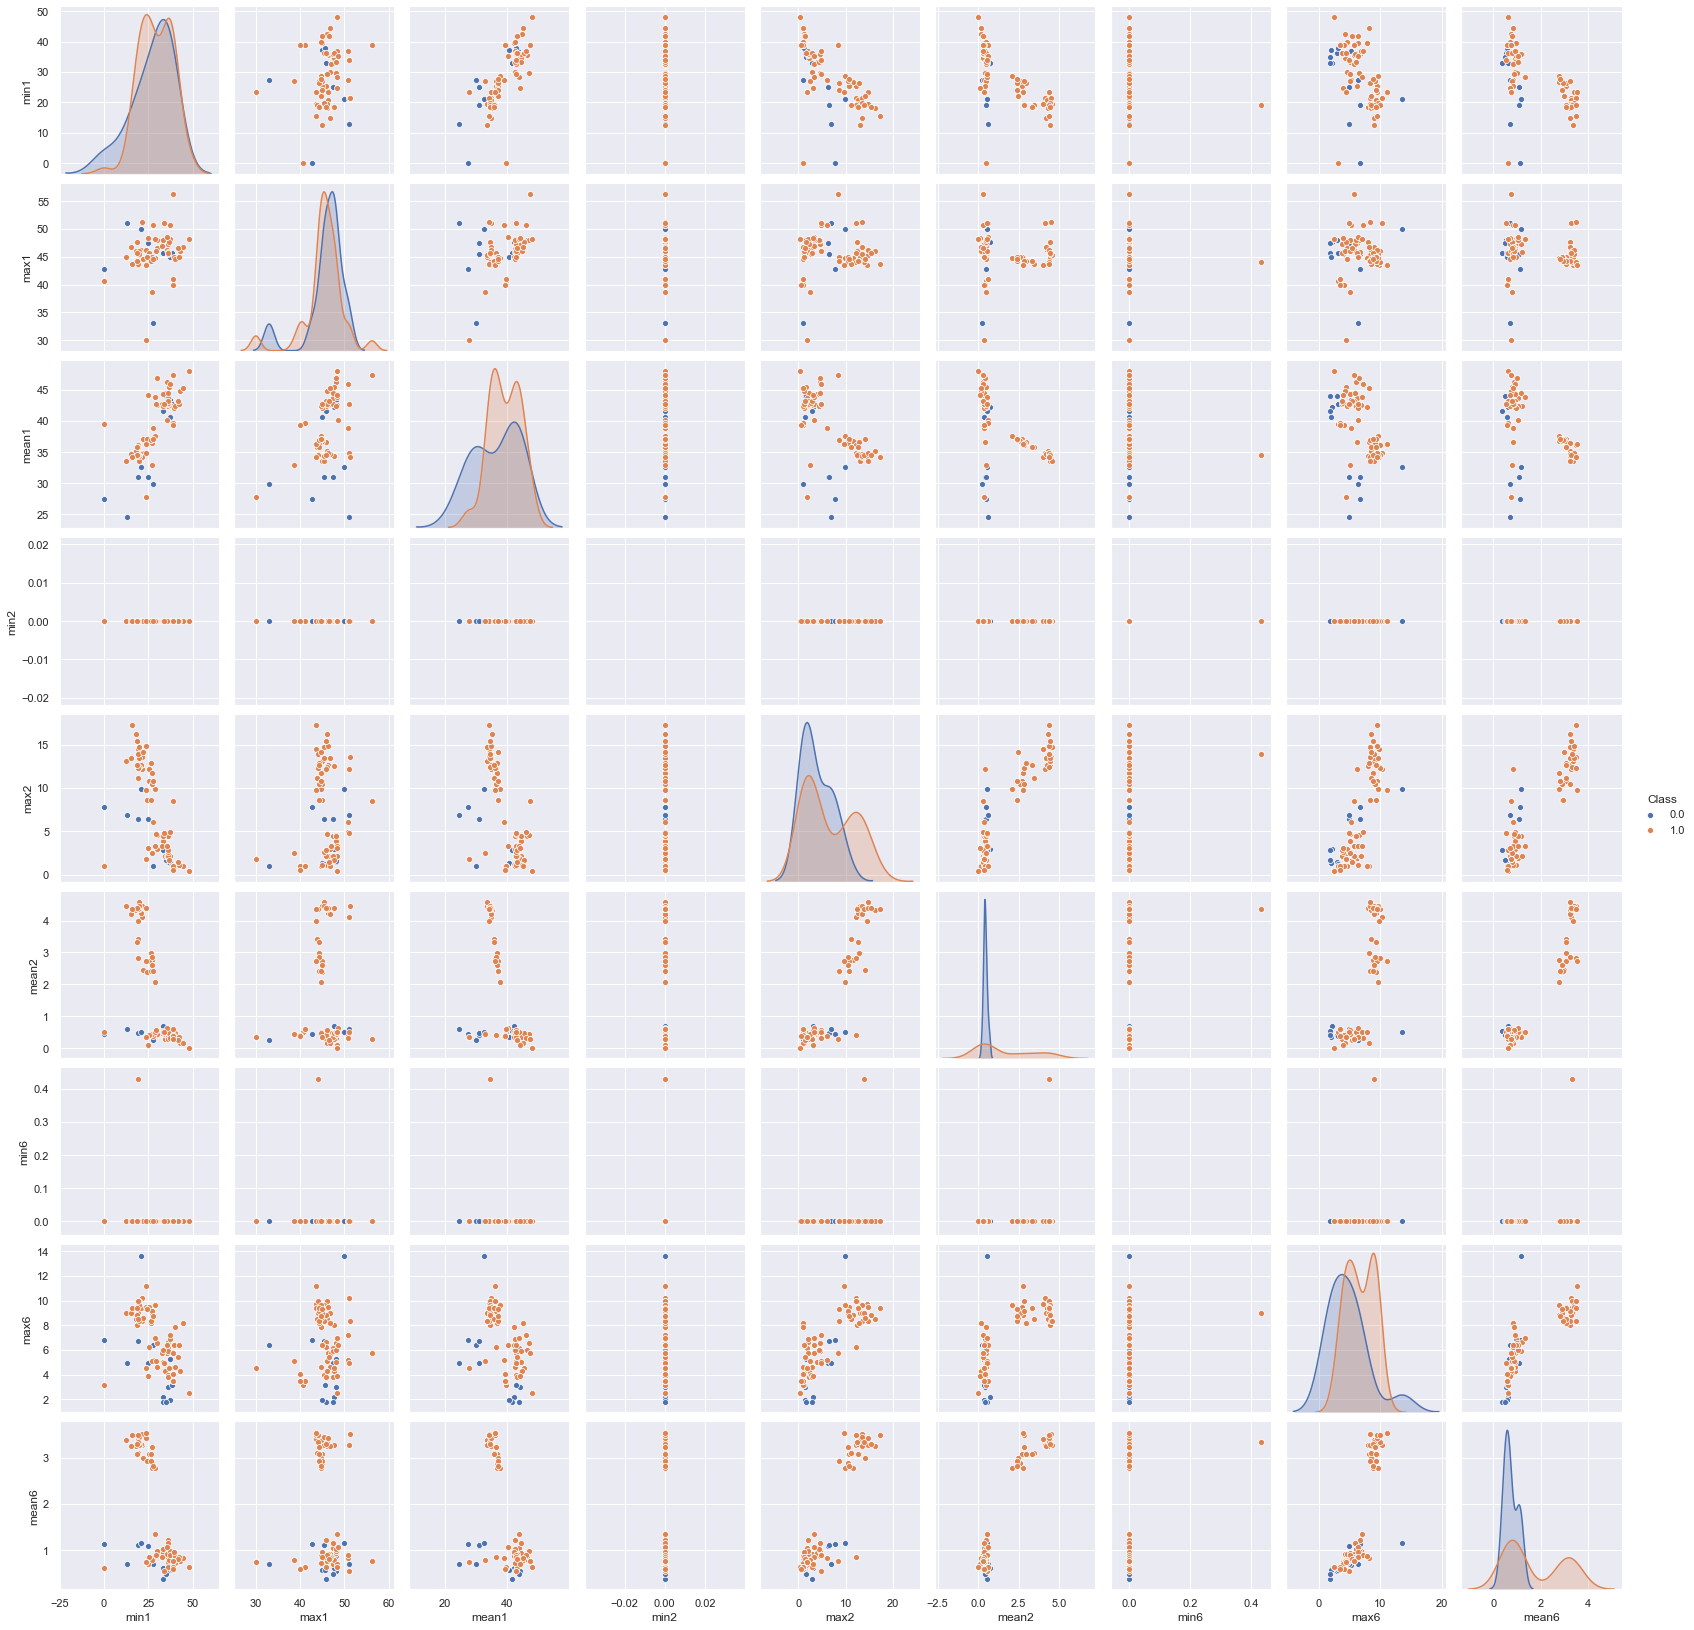

In [5]:
feature_ext_df = feature_ext_df[['Class', 'min1','max1','mean1','min2','max2','mean2','min6','max6','mean6']]
sns.set(style="darkgrid" )
sns.pairplot(feature_ext_df, hue='Class')
plt.show()

2. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


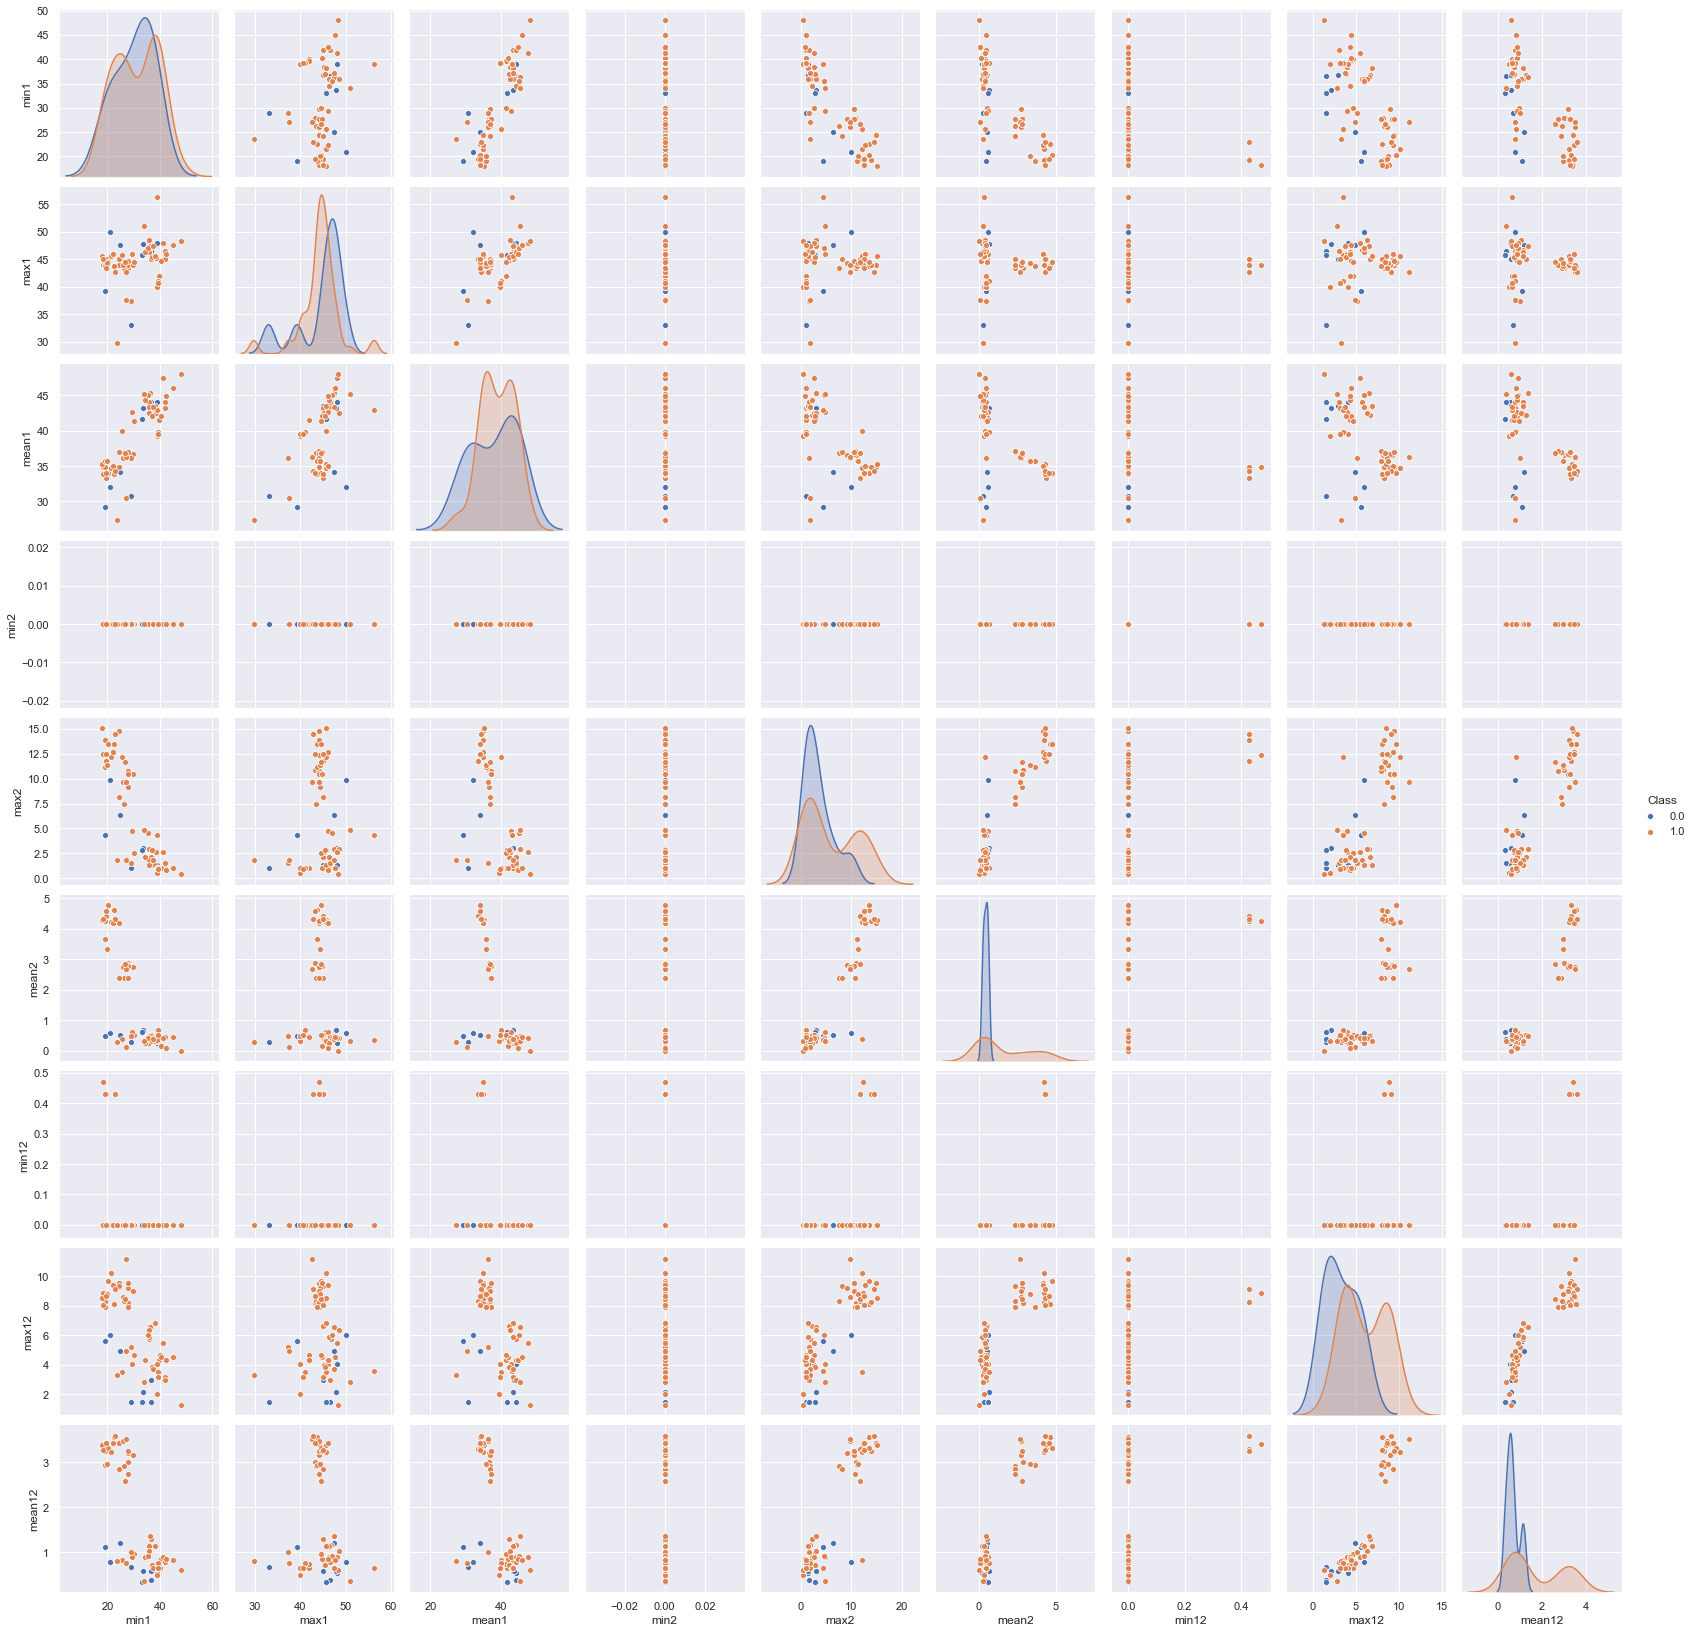

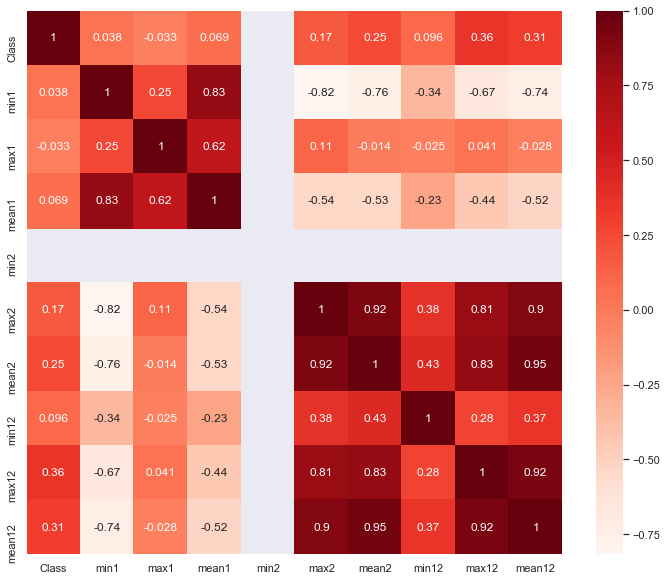

In [6]:
def train_split_stats():
    local_df = extract_features(copy.copy(train_ds),2,13,False,False)
    local_df = local_df[['Class', 'min1','max1','mean1','min2','max2','mean2','min12','max12','mean12']]
    sns.set(style="darkgrid" )
    sns.pairplot(local_df, hue='Class')
    plt.show()
    
    #Using Pearson Correlation
    plt.figure(figsize=(12,10))
    cor = local_df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    
    #Correlation with output variable
    cor_target = abs(cor["Class"])
    
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>0.5]
    
    # print('relevant_features',relevant_features)
    # print(local_df[["min1","min12"]].corr())
    # print(local_df[["max1","mean12"]].corr())

train_split_stats()

# Feature Selection 

## Using Recursive Feature Elimination and 5-fold CV 

### Below are the steps followed to fit an optimal model
#### 1. For hyperparameter C 
- LogisticRegression : Fixed value of C is chosen and set into the logistic regression model. The max_iter and tolerance values were adjusted accordingly to accomadate the convergence for statsmodels analysis as well as for SKLearn. 

#### 2. Feature Selection 
- RFECV : This estimator using 5-fold stratified cross validation is to determine the set of significant features for each fold and features which are insignificant are removed iteratively. Statsmodels started to issue warning stating perfect separation has been observed. So RFECV is set to cv=5 which internally uses K-FoldStratified cross validation to overcome this issue. So,
    1. For every l, RFECV selects the best features for the logistic regression estimator. So for every subset M(i) or model where i-number of features in l, is removed one by one and significance of features is verified. So final set of features is the model with the most significant features for classification.
    2. The best subset selection through Backward elimination is achieved through RFECV. 

#### 3. Model Selection  
- We have 20 models with different deviances. So using statsmodels, we fit Logit estimator with equivalent configuration and estimate model parametrs AIC, BIC, Pseudo R Squared and Deviance. Since statsmodels provides a much accurate estimate, the model with least deviance is selected to fit the optimal model. 
- However, the convergence of the solvers are equally important to estimate the paramters required for model selection. For some values of l, due to large number of features, the solvers dont converge with default values set in the estimators. So the parameters (max_iter and tolerance) for SKLearn and Statsmodels are set to extreme values assuming possibility of convergence. So if convergence is not achieved, the deviance is low (<1) and hence this model has to be fine tuned further for analysis. In such cases, the pvalues and coefficients are calculated using SKLearn approximation to statsmodels as statsmodels doesnt return pvalues if the solver doesnt converge. 

#### 4. Optimal Fit model 
- The optimal model size(l) and set of significant features are provided to fit the optimal model

### Cross Validation
#### Wrong way 
> Performing cross validation only after fitting optimal model (after step 4)
#### Right way 
> Since feature selection is also a part of training process, the right way to perform cross validation would be to use the training set to cross validate and determine the best features using KFold cross validation. Further, once the optimal classifier is fit, using validation set approach, the classifier score is determined against the test set. 
> So performing validation for feature selection as well as after choosing an optimal model is the right way for this problem.

### Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?
> The classes are well separated and we can see testing accuracy close to 94.7%. 

### From the confusion matrices you obtained, do you see imbalanced classes?
> From the confusion matrices for training data, the classes are perfectly balanced. However the confusion matrices on test data show that one of the instances which belongs to Class 0 is misclassified as Class 1. 
> For case control sampling, oversampling using SMOTE and SKLearn resample was tried. So the training instances for Class 0 was increased in small sizes untill it adjusted the precesion and recall score. In the process of balancing the precision and recall score for Class 0, the accuracy was largely compromised. 

Optimization terminated successfully.
         Current function value: 0.496532
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 0.594397
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.481302
         Iterations: 37
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 0.559889
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.555753
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 94
         Function evaluations: 95
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: 0.350253
         Iterations: 99
         Function evaluations: 100
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.379375
         Iterations: 64
         Function evaluations: 65
         Gradient evaluations: 65


/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: 0.485616
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.478580
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.291079
         Iterations: 193
         Function evaluations: 194
         Gradient evaluations: 194
Optimization terminated successfully.
         Current function value: 0.368190
         Iterations: 73
         Function evaluations: 74
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: 0.529115
         Iterations: 8
         Function evaluations: 9
 

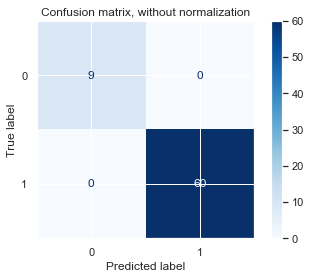


 ###############  Confusion Matrix, ROC & AUC on Test data ############### 

Confusion matrix, without normalization
[[ 3  1]
 [ 0 15]]


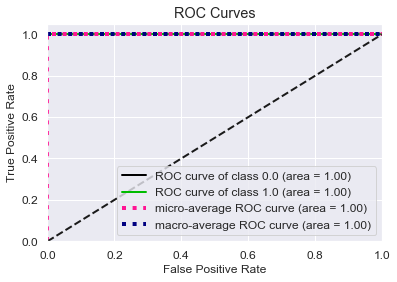

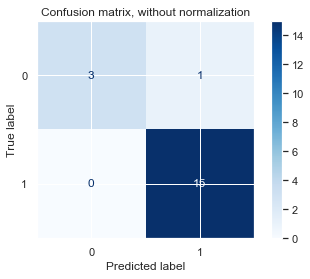

***************** RESAMPLING MINORITY CLASS 0 FOR l = 13 **********************
Shape of X_train before oversampling (69, 21)
Shape of y_train before oversampling (69, 1)
Shape of X_train after oversampling (87, 21)
Shape of y_train after oversampling (87,)

-----------------------------------------------------------
Training Accuracy Score after minority upsampling:  1.0
Test Accuracy Score after minority upsampling:  0.9473684210526315
f1 score macro       : 0.9124423963133641
f1 score micro       : 0.9473684210526315
precision score      : 0.96875
recall score         : 0.875
log_loss             : 1.8178724206495207
zero_one_loss        : 0.052631578947368474
AUC & ROC            : 0.875
classification_report:

               precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.94      1.00      0.97        15

    accuracy                           0.95        19
   macro avg       0.97      0.88      0.91        19
we

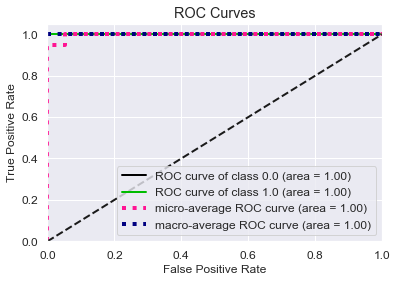

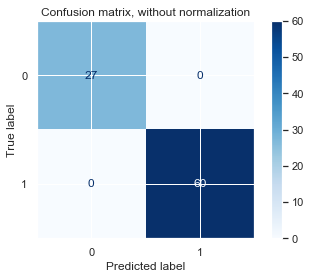


 ###############  Confusion Matrix, ROC & AUC on Test data ############### 

Confusion matrix, without normalization
[[ 3  1]
 [ 0 15]]


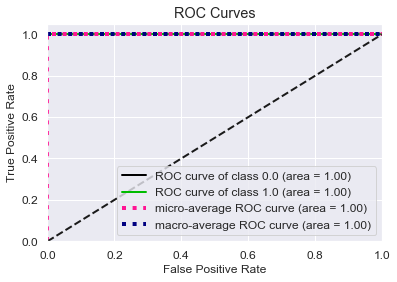

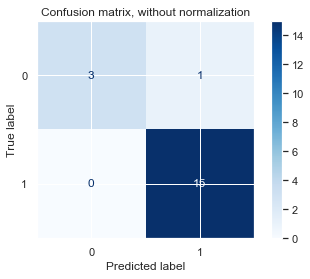

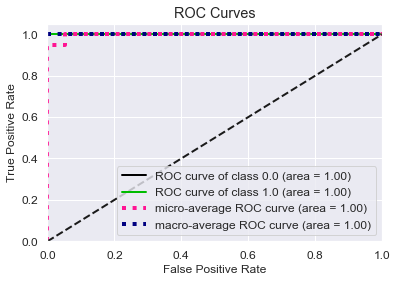

In [7]:
def recursive_feature_elimination_cv():
    
    C=100
    logcv_tol = 1e-7
    logcv_max_iter = 1e9
    statsmodels_tol = 1e-7
    statsmodels_max_iter = 1e9
    
    def rfe_cv():
        
        sklearn_stats = {
            "l":[],
            "Total Features":[],
            "Selected Features":[], 
            "CV Score":[],
            "Pruned Features":[],      
            "Intercept":[],    
            "Residual Deviance" : []
        }
        statsmodels_stats = {
            "l":[],
            "Deviance":[],  
            "Psuedo R Squared":[],
            "AIC":[],
            "BIC":[],
            "Converged" : []
        }
        
        for i in range(1,21,1):

            train_df = extract_features(copy.copy(train_ds),i,(i*6)+1,False,False)
            y_train = np.array(train_df[["Class"]]).ravel()
            X_train = train_df.drop(columns=["Instance","Class"])
            X_train_std = scalar_standardization(X_train)

            clf=LogisticRegression(C=C,tol=logcv_tol,max_iter=logcv_max_iter,n_jobs=-1)
            rfecv = RFECV(estimator=clf,n_jobs=-1)
            rfecv.fit(X_train_std, y_train)

            selected_features = X_train.columns[(rfecv.support_)]              

            # Re-standardize selected features to fit Logit model for stats
            res_sm = sm.Logit(y_train,scalar_standardization(
                X_train_std[selected_features])).fit(method='bfgs',
                                                     maxiter=statsmodels_max_iter, 
                                                     kwargs = {'gtol':statsmodels_tol},
                                                     disp=disp)
            
            deviance = -2*res_sm.llf
            converged = True if deviance > 1  else False
            
            statsmodels_stats["l"].append(i)
            statsmodels_stats["AIC"].append(res_sm.aic)        
            statsmodels_stats["Psuedo R Squared"].append(res_sm.prsquared) 
            statsmodels_stats["Deviance"].append(deviance)
            statsmodels_stats["BIC"].append(res_sm.bic)
            statsmodels_stats["Converged"].append(converged)
            
            sklearn_stats["Pruned Features"].append(selected_features)        
            sklearn_stats["Selected Features"].append(format(rfecv.n_features_))       
            sklearn_stats["Intercept"].append(rfecv.estimator_.intercept_)  
            sklearn_stats["Total Features"].append(format((X_train.shape[1])))
            sklearn_stats["l"].append(i)
            sklearn_stats["CV Score"].append(rfecv.score(X_train_std,y_train)) 
            sklearn_stats["Residual Deviance"].append(
                2*log_loss(y_train, rfecv.predict_proba(X_train_std), normalize=False))

        print(format_table(sklearn_stats))
        print("")
        print(format_table(statsmodels_stats))
                          
        min_deviance_indx=statsmodels_stats["Deviance"].index(cal_min_deviance
                                                              (statsmodels_stats["Deviance"]))
        l = min_deviance_indx + 1
        
        print("-----------------------------------------------------------")
        print("Best (l,p) corresponding to small Deviance (> 1): (",format(l),",",
              format(sklearn_stats["Selected Features"][min_deviance_indx]),")")
        print("-----------------------------------------------------------")
        
        refit_optimal_model(l,sklearn_stats["Pruned Features"][min_deviance_indx],
                            statsmodels_stats["Converged"][min_deviance_indx])
    
    def refit_optimal_model(l,optimal_features,converged):
        
        train_df = extract_features(copy.copy(train_ds),l,(l*6)+1,False,False)
        y_train = np.array(train_df[["Class"]]).ravel()
        X_train = train_df.drop(columns=["Instance","Class"])
        X_train_std = scalar_standardization(X_train[optimal_features])
        
        if bool(converged):
            res_sm = sm.Logit(y_train, X_train_std).fit(method='bfgs',
                                                        maxiter=statsmodels_max_iter, 
                                                        kwargs = {'gtol':statsmodels_tol},
                                                        disp=disp)
            print("\nCoefficients and p-values : \n",format_report(res_sm))
        else:
            clf_ = LogisticRegression(penalty='none',fit_intercept=False)
            clf_.fit(X_train_std,y_train)
            print("\nCoefficients and p-values : \n",format_sklearn_params(clf_,X_train_std))
        
        clf=LogisticRegression(C=C, tol=logcv_tol,max_iter=logcv_max_iter,n_jobs=-1)
        clf.fit(X_train_std, y_train) 
        
        test_df = extract_features(copy.copy(test_ds),l,(l*6)+1,False,False)
        y_test = np.array(test_df[["Class"]])
        X_test = test_df.drop(columns=["Instance","Class"])
        X_test_std = scalar_standardization(X_test[optimal_features])
        y_pred = clf.predict(X_test_std)
 
        print("\n-----------------------------------------------------------")
        print("Training Accuracy Score : ",clf.score(X_train_std,y_train))
        print("Test Accuracy Score : ",clf.score(X_test_std,y_test))
        print(evaluation_analysis(y_test,y_pred))
        print("-----------------------------------------------------------\n")                                             
        
        n_classes = 2
        class_names = ["0","1"]
        y_probas_train = clf.predict_proba(X_train_std)
        y_probas = clf.predict_proba(X_test_std)
        
        
        print('\n ###############  Confusion Matrix, ROC & AUC on Training data ############### \n')
        plt_confusion_matrix(clf, X_train_std, y_train, class_names)
        plt_ski_roc(y_train, y_probas_train)
        
        j=0
        for i in range(1,int(1e5),1):
            j+=1
    
        print('\n ###############  Confusion Matrix, ROC & AUC on Test data ############### \n')
        plt_confusion_matrix(clf, X_test_std, y_test, class_names)
        plt_ski_roc(y_test, y_probas)
        
        resampling(l,optimal_features)
        
    def resampling(l,optimal_features):
        
        print("***************** RESAMPLING MINORITY CLASS 0 FOR l =",l,"**********************")
        
        train_df = extract_features(copy.copy(train_ds),l,(l*6)+1,False,False)
        
        # Minority Upsampling using resample is performed to equalize the sample distribution of the classes
        # train_df = minority_upsampling(under_sampled_df)
        
        y_train_ = np.array(train_df[["Class"]])
        X_train = train_df.drop(columns=["Instance","Class"])
        X_train = X_train[optimal_features]
        
        print('Shape of X_train before oversampling',X_train.shape)
        print('Shape of y_train before oversampling',y_train_.shape)
        
        sm = SMOTE(random_state = 123,sampling_strategy=0.455) 
        X_train_over_samp, y_train = sm.fit_sample(X_train, y_train_) 
        
        print('Shape of X_train after oversampling',X_train_over_samp.shape)
        print('Shape of y_train after oversampling',y_train.shape)
        
        X_train_std = scalar_standardization(X_train_over_samp)
        
        clf=LogisticRegression(C=C, tol=logcv_tol,max_iter=logcv_max_iter,n_jobs=-1)
        clf.fit(X_train_std, y_train) 
        
        test_df = extract_features(copy.copy(test_ds),l,(l*6)+1,False,False)
        y_test = np.array(test_df[["Class"]])
        X_test = test_df.drop(columns=["Instance","Class"])
        X_test_std = scalar_standardization(X_test[optimal_features])
        y_pred = clf.predict(X_test_std)

        print("\n-----------------------------------------------------------")
        print("Training Accuracy Score after minority upsampling: ",clf.score(X_train_std,y_train))
        print("Test Accuracy Score after minority upsampling: ",clf.score(X_test_std,y_test))
        print(evaluation_analysis(y_test,y_pred))
        print("-----------------------------------------------------------\n")                                             
        
        n_classes = 2
        class_names = ["0","1"]
        y_probas_train = clf.predict_proba(X_train_std)
        y_probas = clf.predict_proba(X_test_std)
        
        print('\n ###############  Confusion Matrix, ROC & AUC on Training data ############### \n')
        plt_confusion_matrix(clf, X_train_std, y_train, class_names)   
        plt_ski_roc(y_train, y_probas_train)
        
        j=0
        for i in range(1,int(1e5),1):
            j+=1
        
        print('\n ###############  Confusion Matrix, ROC & AUC on Test data ############### \n')
        plt_confusion_matrix(clf, X_test_std, y_test, class_names)   
        plt_ski_roc(y_test, y_probas)
        
    rfe_cv()
recursive_feature_elimination_cv()

## Using L1 Regularized Logistic Regression
Repeat 1(d)iii using $ \mathcal{L}1$-penalized logistic regression, i.e. instead of using p-
values for variable selection, use L1 regularization. Note that in this problem,
you have to cross-validate for both l, the number of time series into which you
break each of your instances, and λ, the weight of L1 penalty in your logistic
regression objective function (or C, the budget). 

### Below are the steps followed to fit an optimal model 
#### 1. For hyperparameter C  
- LogisticRegressionCV : A range of Cs are specified for this attribute in the model attributes. This model automatically cross validates. Here cv=5 is set. The default cross-validation generator used is Stratified K-Folds. If an integer is provided, then it is the number of folds used. This estimator selects best C value (corresponding to maximum cross validation score) and fits the final model.

#### 2. To obtain pruned features 
- LogisticRegressionCV : This estimator is set with penalty=l1 which means $ \mathcal{L}1$-regularized logistic regression. The features which are insignificant (higher p-value) are removed by this estimator for each fold by applying $ \mathcal{L}1$-regularizion. We can retrieve reduced set of highly significant features through method with help of SelectFromModel.

#### 3. Model Selection 
- We have 20 models with different deviances. So using statsmodels, we fit Logit estimator equivalent configuration and estimate model parametrs AIC, BIC, Pseudo R Squared and Deviance. Since statsmodels provides a much accurate estimate, the model with least deviance is selected to fit the optimal model.

#### 4. Optimal Fit model
- The best hyperparameter value, optimal model size(l) and set of significant features are provided to fit the optimal model

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3678231023323872
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.38676395009175846
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.36646786152756083
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3681581152989336
            Iterations: 64
            Function evaluations: 64
            Gradient evaluations: 64
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4105431072370933
            Iterations: 29
            Funct

/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.479057416581502e-11
            Iterations: 60
            Function evaluations: 61
            Gradient evaluations: 60
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.32432539081183276
            Iterations: 67
            Function evaluations: 67
            Gradient evaluations: 67
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3621024985015513
            Iterations: 64
            Function evaluations: 64
            Gradient evaluations: 64
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.30320634002275776
            Iterations: 77
            Function evaluations: 77
            Gradient evaluations: 77
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.32522513941519926
            Iterations: 71
            F

/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.564775068371787e-11
            Iterations: 105
            Function evaluations: 106
            Gradient evaluations: 105


/Users/lsandip/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.691359324441777e-11
            Iterations: 100
            Function evaluations: 101
            Gradient evaluations: 100
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.23471035064404874
            Iterations: 103
            Function evaluations: 103
            Gradient evaluations: 103
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.20622938127612012
            Iterations: 90
            Function evaluations: 90
            Gradient evaluations: 90
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3172495782352731
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3290963091706079
            Iterations: 46
        

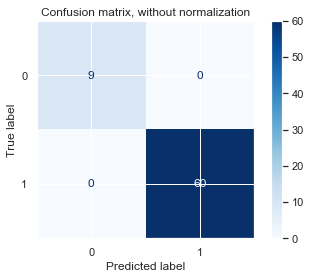

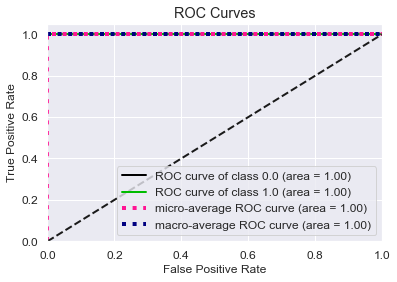

In [8]:
def L1_penalized_regression():
    
    def five_fold_cv():
        
        sklearn_stats = {
            "l":[],
            "Total Features":[],
            "Selected Features":[], 
            "CV Training Score":[],
            "Pruned Features":[],      
            "Best C":[],    
            "Residual Deviance" : []
        }
        statsmodels_stats = {
            "l":[],
            "Deviance":[],  
            "Psuedo R Squared":[],
            "AIC":[],
            "BIC":[], 
            "Converged":[]
        }
        
        for i in range(1,21,1):
            
            train_df = extract_features(copy.copy(train_ds),i,(i*6)+1,False,False)
            y_train = np.array(train_df[["Class"]]).ravel()
            X_train = train_df.drop(columns=["Instance","Class"])
            X_train_std = scalar_standardization(X_train)
            
            clf=LogisticRegressionCV(Cs=np.logspace(-1,3,num=50,base=10.0),
                                     penalty='l1',
                                     solver='liblinear',
                                     n_jobs=-1,
                                     cv=5,
                                     max_iter=1e9,
                                     tol=1e-10)    
            clf.fit(X_train_std, y_train)
            
            sel_ = SelectFromModel(clf)
            sel_.fit(X_train_std, y_train.ravel())
            selected_features = X_train_std.columns[(sel_.get_support())] 
            
            # Re-standardize selected features to fit Logit model for stats
            X_train_re_std = scalar_standardization(X_train[selected_features])
            res_sm = sm.Logit(y_train,X_train_re_std).fit_regularized(method='l1',
                                                                      maxiter=1e9,
                                                                      disp=disp) #maxiter=1e9
            deviance = -2*res_sm.llf
            converged = True if deviance > 1  else False
    
            statsmodels_stats["l"].append(i)
            statsmodels_stats["AIC"].append(res_sm.aic)        
            statsmodels_stats["Psuedo R Squared"].append(res_sm.prsquared)              
            statsmodels_stats["Deviance"].append(deviance)
            statsmodels_stats["BIC"].append(res_sm.bic)
            statsmodels_stats["Converged"].append(converged)
            
            sklearn_stats["Best C"].append(clf.C_)     
            sklearn_stats["Pruned Features"].append(selected_features)        
            sklearn_stats["Selected Features"].append(len(selected_features))    
            sklearn_stats["Total Features"].append(format((X_train_std.shape[1])))
            sklearn_stats["l"].append(i)
            sklearn_stats["CV Training Score"].append(clf.score(X_train_std,y_train)) 
            sklearn_stats["Residual Deviance"].append(2*log_loss(y_train, 
                                                                 clf.predict_proba(X_train_std), 
                                                                 normalize=False))
        
        print(format_table(sklearn_stats))
        print("")
        print(format_table(statsmodels_stats))
                          
        min_deviance_indx=statsmodels_stats["Deviance"].index(cal_min_deviance
                                                              (statsmodels_stats["Deviance"]))
        l = min_deviance_indx + 1
        
        print("-----------------------------------------------------------")
        print("Best (l,p) corresponding to small Deviance (>1): (",format(l),",",
              format(sklearn_stats["Selected Features"][min_deviance_indx]),")")
        print("-----------------------------------------------------------")
        
        refit_optimal_model(l,sklearn_stats["Pruned Features"]
                            [min_deviance_indx],sklearn_stats["Best C"][min_deviance_indx],
                            statsmodels_stats["Converged"][min_deviance_indx])
    
    def refit_optimal_model(l,optimal_features,C,converged):
            
        train_df = extract_features(copy.copy(train_ds),l,(l*6)+1,False,False)
        y_train = np.array(train_df[["Class"]]).ravel()
        X_train = train_df.drop(columns=["Instance","Class"])
        X_train_std = scalar_standardization(X_train[optimal_features])
        
        if bool(converged):
            res = sm.Logit(y_train, X_train_std).fit_regularized(method='l1', 
                                                                 maxiter=1e5,
                                                                 disp=disp)
            print("\nCoefficients and p-values : \n",format_report(res))
        else:
            clf_ = LogisticRegression(penalty='l1',
                                      fit_intercept=False, 
                                      solver='liblinear', 
                                      C=1e20)
            clf_.fit(X_train_std,y_train)
            print("\nCoefficients and p-values : \n",format_sklearn_params(clf_,X_train_std))
        
        #res = sm.Logit(y_train, X_train_std).fit_regularized(method='l1',maxiter=1e5,disp=disp)
        
        clf=LogisticRegression(penalty='l1',solver='liblinear',C=C[0])
        clf.fit(X_train_std, y_train) 
        
        test_df = extract_features(copy.copy(test_ds),l,(l*6)+1,False,False)
        y_test = np.array(test_df[["Class"]]).ravel()
        X_test = test_df.drop(columns=["Instance","Class"])
        X_test_std = scalar_standardization(X_test[optimal_features])
        y_pred = clf.predict(X_test_std)
        
        print("\n-----------------------------------------------------------")
        print("Training Accuracy Score : ",clf.score(X_train_std,y_train))
        print("Test Accuracy Score : ",clf.score(X_test_std,y_test))
        print(evaluation_analysis(y_test,y_pred))
        print("-----------------------------------------------------------\n")                                             
        
        n_classes = 2
        class_names = ["0","1"]
        
        y_probas = clf.predict_proba(X_train_std)
        y_probas_test = clf.predict_proba(X_test_std)
        plt_confusion_matrix(clf, X_train_std, y_train,class_names)   
        plt_ski_roc(y_train, y_probas)
        
        j=0
        for i in range(1,int(1e5),1):
            j+=1
    
        print('\n ###############  Confusion Matrix, ROC & AUC on Test data ############### \n')
        plt_confusion_matrix(clf, X_test_std, y_test, class_names)
        plt_ski_roc(y_test, y_probas_test)
    
    five_fold_cv()                           
L1_penalized_regression()

## L1 Penalized Logistic Regression vs RFECV 
RFECV selects the features by eliminating one feature at a time which is least significant and considers all the remaining features again to remove them iteratively. Hence it is computationally more expensive. In contrast, L1 penalized regularization (Lasso) is faster and better in terms of perfromance. It eliminates most the insignificant features and gives least optimal features as compared to RFECV. Based on the analysis, we can say that L1 penalized logistsic regression is better choice here.  

# Multi-class Classification
> The best classifier here is determined by the testing accuracy score which is found to be Gaussian Naive Bayes Clasiifier with a testing accuracy close to 94.73%
## 1. L1-Penalized Multinomial Logistic Regression

+----+----------------+-------------------+--------------------+---------------------+--------------------+
| l  | Total Features | Selected Features |      CV Score      |        Best C       |      Deviance      |
+----+----------------+-------------------+--------------------+---------------------+--------------------+
| 1  |       42       |         18        | 0.9855072463768116 |  0.6551285568595507 | 33.16086696612036  |
| 2  |       84       |         72        |        1.0         |  3.5564803062231287 |  9.34999889075377  |
| 3  |      126       |        124        |        1.0         |  9.102981779915218  | 5.870096539505927  |
| 4  |      168       |         43        | 0.9710144927536232 |  0.3088843596477481 | 54.98915430777419  |
| 5  |      210       |        210        |        1.0         |  49.417133613238335 | 2.7827336286705746 |
| 6  |      252       |         74        |        1.0         | 0.44984326689694454 | 37.56756289010585  |
| 7  |      294       |     

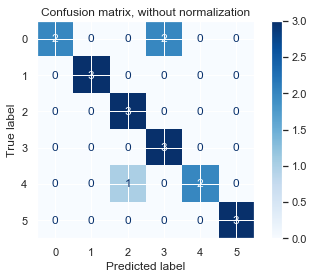

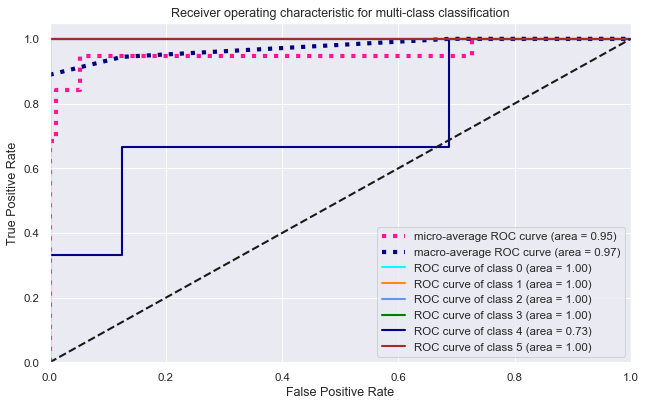

In [9]:
def multiclass_classification():
    
    def multinomial_regression():
        
        sklearn_stats = {
            "l":[],
            "Total Features":[],
            "Selected Features":[], 
            "CV Score":[],
            "Pruned Features":[],      
            "Best C":[],    
            "Deviance" : []
        }
#         statsmodels_stats = {
#             "l":[],
#             "Deviance":[],  
#             "Psuedo R Squared":[],
#             "AIC":[],
#             "BIC":[], 
#         }
        
        for i in range(1,21,1):
        
            train_df = extract_features(copy.copy(train_ds),i,(i*6)+1,False,True)
            y_train = np.array(train_df[["Class"]]).ravel()
            X_train = train_df.drop(columns=["Instance","Class"])
            X_train_std = scalar_standardization(X_train)
            
            # print('Executing LogReg CV for split ...',i)
            
            mult_clf = LogisticRegressionCV(Cs=np.logspace(-1,3,num=50,base=10.0), 
                                            multi_class="multinomial",
                                            penalty='l1', 
                                            tol=1e-3, 
                                            solver='saga',
                                            max_iter=1e5 ,
                                            cv=5,
                                            n_jobs=-1)
            mult_clf.fit(X_train_std, y_train.ravel())
            
            sel_ = SelectFromModel(mult_clf)
            sel_.fit(X_train_std, y_train.ravel())
            selected_features = X_train_std.columns[(sel_.get_support())] 
    
            # Re-standardize selected features to fit Logit model for stats
            X_train_re_std = scalar_standardization(X_train[selected_features])
            
            # res_sm = sm.MNLogit(y_train,sm.add_constant(X_train_re_std)).fit_regularized(method='l1') #maxiter=1e9
            # res_sm = sm.MNLogit(y_train,sm.add_constant(X_train_re_std)).fit()
            
            # statsmodels_stats["l"].append(i)
            # statsmodels_stats["AIC"].append(res_sm.aic)        
            # statsmodels_stats["Psuedo R Squared"].append(res_sm.prsquared)              
            # statsmodels_stats["Deviance"].append(-2*res_sm.llf)
            # statsmodels_stats["BIC"].append(res_sm.bic)
            
            sklearn_stats["Selected Features"].append(len(selected_features))    
            sklearn_stats["Total Features"].append(format((X_train_std.shape[1])))
            sklearn_stats["l"].append(i)  
            sklearn_stats["Best C"].append(mult_clf.C_[0])     
            sklearn_stats["Pruned Features"].append(selected_features)        
            sklearn_stats["CV Score"].append(mult_clf.score(X_train_std,y_train)) 
            sklearn_stats["Deviance"].append(2*log_loss(y_train, 
                                                        mult_clf.predict_proba(X_train_std), 
                                                        normalize=False)) 
            
            # print('Completed fitting SKLearn model for split ...',i)
        
        print(format_table(sklearn_stats))
        print("")
        
        # print(format_table(statsmodels_stats))                 
        # min_deviance_indx=statsmodels_stats["Deviance"].index(cal_min_deviance(statsmodels_stats["Deviance"]))
        
        min_deviance_indx=sklearn_stats["Deviance"].index(cal_min_deviance(sklearn_stats["Deviance"]))
        l = min_deviance_indx + 1
        
        
        print("-----------------------------------------------------------")
        print("Best (l,p) corresponding to small Deviance (> 1): (",format(l),",",
              format(sklearn_stats["Selected Features"][min_deviance_indx]),")")
        print("-----------------------------------------------------------")
        
        refit_optimal_model(l,sklearn_stats["Pruned Features"]
                            [min_deviance_indx],sklearn_stats["Best C"][min_deviance_indx])
    
    def refit_optimal_model(l,optimal_features,C):

        n_classes = 6    
        train_df = extract_features(copy.copy(train_ds),l,(l*6)+1,False,True)
        test_df = extract_features(copy.copy(test_ds),l,(l*6)+1,False,True)
        
        y_train = np.array(train_df[["Class"]]).ravel()
        X_train = train_df.drop(columns=["Instance","Class"])
        X_train_std = scalar_standardization(X_train[optimal_features])

        y_test = np.array(test_df[["Class"]]).ravel()
        X_test = test_df.drop(columns=["Instance","Class"])
        X_test_std = scalar_standardization(X_test[optimal_features])
        
        # on standardized data
        _clf = LogisticRegression(C=C, multi_class="multinomial",
                                  penalty='l1', solver='saga',
                                  max_iter=1e5, tol=1e-3)
        _clf.fit(X_train_std, y_train.ravel())
        
        print("Training Accuracy :",_clf.score(X_train_std, y_train))
        print("Testing Accuracy :",_clf.score(X_test_std, y_test))
        
        y_pred = _clf.predict(X_test_std)
        
        class_names=np.array([0,1,2,3,4,5])
        plt_confusion_matrix(_clf, X_test_std, y_test,class_names) 
        
        y_train_ = label_binarize(np.array(train_df[["Class"]]),classes=class_names)
        y_test_ = label_binarize(np.array(test_df[["Class"]]),classes=class_names)
        
        # classifier to plot roc curve for multilabel 
        roc_clf = OneVsRestClassifier(LogisticRegression(C=C, multi_class="multinomial",
                                                         penalty='l1', solver='saga',
                                                         tol=1e-3,max_iter=1e5))
        y_score = roc_clf.fit(X_train_std, y_train_).predict_proba(X_test_std)
        plot_multiclass_roc(y_test_, y_score, n_classes)
        
    multinomial_regression()                           
multiclass_classification()

## 2. Gaussian Naive Bayes Classifier

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    6.2s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    6.8s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    7.5s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    8.1s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    8.8s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    9.3s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   10.0s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   10.6s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   11.2s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   11.9s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   12.5s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   13.2s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   13.7s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   14.4s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   14.9s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   15.6s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   16.3s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   16.9s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   17.6s finished


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   18.1s finished


+----+--------------------+---------------------+
| l  |     Best Score     |    Var Smoothing    |
+----+--------------------+---------------------+
| 1  | 0.9135531135531136 | 0.08111308307896872 |
| 2  | 0.8941391941391943 | 0.03511191734215131 |
| 3  | 0.8505494505494506 | 0.02848035868435802 |
| 4  | 0.8604395604395605 | 0.02848035868435802 |
| 5  | 0.8750915750915751 |         0.1         |
| 6  | 0.8652014652014652 | 0.08111308307896872 |
| 7  | 0.904029304029304  | 0.02848035868435802 |
| 8  | 0.8695970695970696 | 0.04328761281083057 |
| 9  | 0.8505494505494506 | 0.08111308307896872 |
| 10 | 0.8604395604395605 | 0.04328761281083057 |
| 11 | 0.8648351648351649 | 0.01873817422860384 |
| 12 | 0.8358974358974359 | 0.08111308307896872 |
| 13 | 0.8501831501831504 | 0.03511191734215131 |
| 14 | 0.8787545787545789 | 0.02310129700083159 |
| 15 |  0.86007326007326  | 0.02848035868435802 |
| 16 | 0.8457875457875458 |  0.0533669923120631 |
| 17 |  0.86996336996337  | 0.04328761281083057 |


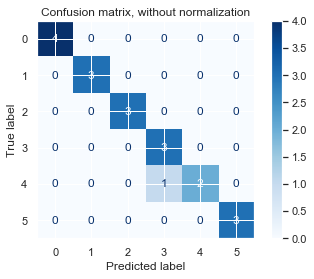

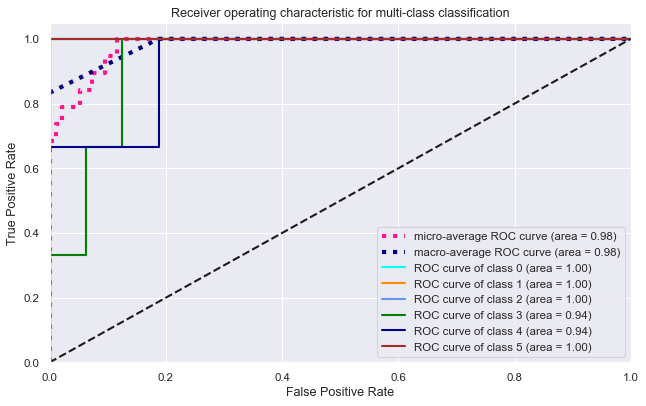

In [10]:
def gaussianNB():
    
    def GaussianNB_V():
        
        sklearn_stats = {
            "l":[],
            "Best Score":[],
            "Var Smoothing":[]
        }
    
        for i in range(1,21,1):
            
            train_df = extract_features(copy.copy(train_ds),i,(i*6)+1,False,True)
            
            y_train = np.array(train_df[["Class"]])
            X_train = train_df.drop(columns=["Instance","Class"])

            cv_method = RepeatedStratifiedKFold(n_splits=5,
                                                n_repeats=3, 
                                                random_state=999)

            nb_classifier = GaussianNB()
            params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

            gs_NB = GridSearchCV(estimator=nb_classifier,
                                 param_grid=params_NB, 
                                 cv=cv_method,
                                 verbose=1, 
                                 scoring='accuracy')

            gs_NB.fit(scalar_standardization(X_train), y_train.ravel())
            
            sklearn_stats["l"].append(i)
            sklearn_stats["Best Score"].append(gs_NB.best_score_)
            sklearn_stats["Var Smoothing"].append(gs_NB.best_params_['var_smoothing'])
            
        table = PrettyTable()
        for key,val in sklearn_stats.items():
            table.add_column(key, val)

        print(table)
        
        max_test_accu = max(sklearn_stats["Best Score"])
        max_test_accu_indx = sklearn_stats["Best Score"].index(max_test_accu)
        l = max_test_accu_indx + 1
        
        print("-----------------------------------------------------------")
        print("Best (l) corresponding to highest Accuracy: (",format(l),",",
              format(sklearn_stats["Best Score"][max_test_accu_indx]),")")
        print("-----------------------------------------------------------")
        
        refit_optimal_model(l,sklearn_stats["Var Smoothing"][max_test_accu_indx])
        
    def refit_optimal_model(l,var_smoothing):
        
        train_df = extract_features(copy.copy(train_ds),l,(l*6)+1,False,True)
        test_df = extract_features(copy.copy(test_ds),l,(l*6)+1,False,True)
        
        y_train = np.array(train_df[["Class"]]).ravel()
        n_classes = 6
        X_train = train_df.drop(columns=["Instance","Class"])
        X_train_std = scalar_standardization(X_train)

        y_test = np.array(test_df[["Class"]]).ravel()
        X_test = test_df.drop(columns=["Instance","Class"])
        X_test_std = scalar_standardization(X_test)
        
        # on standardized data
        _clf = GaussianNB(var_smoothing=var_smoothing)
        _clf.fit(X_train_std, y_train.ravel())
        
        print("Training Accuracy :",_clf.score(X_train_std, y_train))
        print("Testing Accuracy :",_clf.score(X_test_std, y_test))
        
        y_pred = _clf.predict(X_test_std)
        class_names=np.array([0,1,2,3,4,5])
        
        plt_confusion_matrix(_clf, X_test_std, y_test,class_names) 
        
        y_train_ = label_binarize(np.array(train_df[["Class"]]),classes=class_names)
        y_test_ = label_binarize(np.array(test_df[["Class"]]),classes=class_names)
        
        # classifier to plot roc curve for multilabel 
        roc_clf = OneVsRestClassifier(GaussianNB(var_smoothing=var_smoothing))
        y_score = roc_clf.fit(X_train_std, y_train_).predict_proba(X_test_std)
        plot_multiclass_roc(y_test_, y_score, n_classes)
        
        
       
    GaussianNB_V()   
gaussianNB()

## 3. Multinomial Naive Bayes Classifier

Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 20624 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 29985 out of 30000 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:   10.7s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:    9.3s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:    9.5s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:    9.6s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:    9.7s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:    9.9s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:    9.9s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:   10.1s finished


Fitting 15 folds for each of 2000 candidates, totalling 30000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 30000 out of 30000 | elapsed:   10.1s finished


+---+--------------------+-----------------------+
| l |     Best Score     |         Alpha         |
+---+--------------------+-----------------------+
| 1 | 0.7516483516483518 |  0.031009004502251122 |
| 2 | 0.7582417582417583 |  0.02100600300150075  |
| 3 | 0.6996336996336995 |   0.6386913456728364  |
| 4 | 0.709157509157509  |  0.25357578789394697  |
| 5 | 0.7673992673992674 |   0.5711710855427713  |
| 6 | 0.7384615384615383 |   0.0785232616308154  |
| 7 | 0.7820512820512822 | 0.0035007503751875936 |
| 8 | 0.772161172161172  | 0.0035007503751875936 |
| 9 | 0.753113553113553  |   0.5686703351675837  |
+---+--------------------+-----------------------+
-----------------------------------------------------------
Best (l) corresponding to highest Accuracy: ( 7 , 0.7820512820512822 )
-----------------------------------------------------------
Training Accuracy : 0.9565217391304348
Testing Accuracy : 0.8421052631578947
Confusion matrix, without normalization
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]

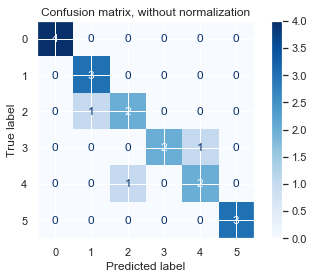

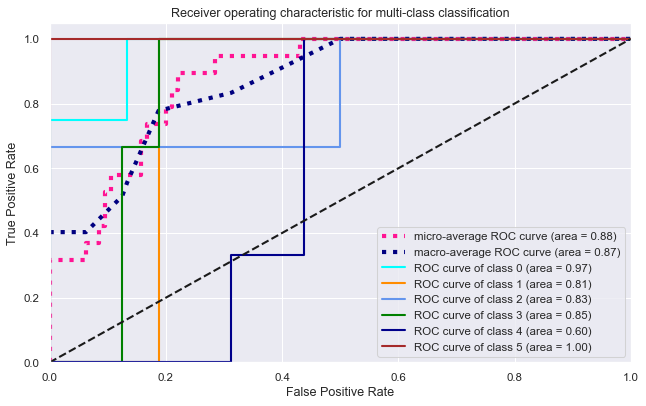

In [11]:
def mulinomial_NB():
    
    def mulinomial_NB_CV():
        
        sklearn_stats = {
            "l":[],
            "Best Score":[],
            "Alpha":[]
        }
    
        for i in range(1,21,1):
            
            train_df = extract_features(copy.copy(train_ds),i,(i*6)+1,False,True)
            
            y_train = np.array(train_df[["Class"]])
            X_train = train_df.drop(columns=["Instance","Class"])

            cv_method = RepeatedStratifiedKFold(n_splits=5,
                                                n_repeats=3, 
                                                random_state=999)

            mnb_classifier = MultinomialNB()

            params_MNB = {'alpha': np.linspace(1e-3,5,2000)}

            gs_NB = GridSearchCV(estimator=mnb_classifier, 
                                 param_grid=params_MNB, 
                                 cv=cv_method,
                                 verbose=1, 
                                 n_jobs=-1,
                                 scoring='accuracy')

            Data_transformed = MinMaxScaler().fit_transform(X_train)

            gs_NB.fit(Data_transformed, y_train.ravel())
            
            sklearn_stats["l"].append(i)
            sklearn_stats["Best Score"].append(gs_NB.best_score_)
            sklearn_stats["Alpha"].append(gs_NB.best_params_['alpha'])
            
        table = PrettyTable()
        for key,val in sklearn_stats.items():
            table.add_column(key, val)

        print(table)
        
        max_test_accu = max(sklearn_stats["Best Score"])
        max_test_accu_indx = sklearn_stats["Best Score"].index(max_test_accu)
        l = max_test_accu_indx + 1
        
        print("-----------------------------------------------------------")
        print("Best (l) corresponding to highest Accuracy: (",format(l),",",
              format(sklearn_stats["Best Score"][max_test_accu_indx]),")")
        print("-----------------------------------------------------------")
        
        refit_optimal_model(l,sklearn_stats["Alpha"][max_test_accu_indx])
        
    def refit_optimal_model(l,alpha):
        
        sc = MinMaxScaler()
        n_classes = 6
            
        train_df = extract_features(copy.copy(train_ds),l,(l*6)+1,False,True)
        test_df = extract_features(copy.copy(test_ds),l,(l*6)+1,False,True)
        
        y_train = np.array(train_df[["Class"]]).ravel()
        X_train = train_df.drop(columns=["Instance","Class"])
        X_train_std = sc.fit_transform(X_train)

        y_test = np.array(test_df[["Class"]]).ravel()
        X_test = test_df.drop(columns=["Instance","Class"])
        X_test_std = sc.fit_transform(X_test)
        
        # on standardized data
        _clf = MultinomialNB(alpha=alpha)
        _clf.fit(X_train_std, y_train.ravel())
        
        print("Training Accuracy :",_clf.score(X_train_std, y_train))
        print("Testing Accuracy :",_clf.score(X_test_std, y_test))
        
        y_pred = _clf.predict(X_test_std)
        class_names=np.array([0,1,2,3,4,5])
        
        plt_confusion_matrix(_clf, X_test_std, y_test,class_names) 
        
        y_train_ = label_binarize(np.array(train_df[["Class"]]),classes=class_names)
        y_test_ = label_binarize(np.array(test_df[["Class"]]),classes=class_names)
        
        # classifier to plot roc curve for multilabel 
        roc_clf = OneVsRestClassifier(MultinomialNB(alpha=alpha))
        y_score = roc_clf.fit(X_train_std, y_train_).predict_proba(X_test_std)
        plot_multiclass_roc(y_test_, y_score, n_classes)
        
        
       
    mulinomial_NB_CV()   
mulinomial_NB()